<a href="https://colab.research.google.com/github/lacrendic/flow-matching/blob/master/flow-matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow Matching for Generative Modeling
_notebook by Georges Le Bellier_  - [Twitter](https://twitter.com/_lebellig), [Website](https://gle-bellier.github.io)


⚠️ This is not the official implementation of the original paper.



This notebook centers around the **Flow Matching for Generative Modeling** article [1] and proposes an implementation of _Flow Matching_ in the case of _Optimal Transport conditional Vector Fields_. The implementation proposed in [2] was consulted and it inspired the use of the _Zuko_ [3] package for ODE solving and sampling. Moreover, this notebook adopts the notations of the original article and thus the numbers of the equations are the same as in the paper.

## References:

📄 [1] **Flow Matching for Generative Modeling** by Yaron Lipman, Ricky T. Q. Chen, Heli Ben-Hamu, Maximilian Nickel, Matt Le - [Article](https://arxiv.org/abs/2210.02747)

🐍 [2] **Flow Matching in 100 LOC** by François Rozet - [Implementation](https://gist.github.com/francois-rozet/fd6a820e052157f8ac6e2aa39e16c1aa)

🐍 [3] **Zuko** package - [Website](https://zuko.readthedocs.io/en/stable/index.html)

📄 [4] **Score-Based Generative Modeling through Stochastic Differential Equations** by Yang Song, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, Ben Poole - [Article](https://arxiv.org/abs/2011.13456)


## Introduction

The article [1] reminds the reader with the following notations:
- $\mathbb{R}^d$ denote the adata space with data points $x = (x^1, ..., x^d) \in \mathbb{R}^d$.
- $v: [0, 1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ is the _time-dependant vector field_.
- $\phi: [0, 1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ is a _flow_. A flow is associated to a vector field $v_t$ thanks to the following equations:
$$
\begin{cases}
  \frac{d}{dt}\phi_t(x) = v_t(\phi_t(x))\\
  \phi_0(x) = x \tag{1, 2}\\
\end{cases}
$$

The main idea is then to use a neural network to model the vector field $v_t$, which implies that $\phi_t$ will also be a parametric model and we call it a  _Continuous Normalizing Flow_ (CNF). In the context of generative modeling, the CNF allows us to transform a simple prior distribution (_e.g._ gaussian) $p_0$ into a more complex one $p_1$ (which we want close to the data distribution $q$ we need to model) by using the _push-forward equation_:
$$
 p_t = [\phi_t]_*p_0 \tag{3}
$$
Where:
$$
 \forall x \in \mathbb{R}^2, [\phi_t]_*p_0(x) = p_0(\phi^{-1}(x))\det\left[\frac{\partial\phi_t^{-1}}{\partial x}(x)\right]
$$




Thus the _Flow Matching_ aims at learning the true vector field $u_t$:

$$
\mathcal{L}_{FM}(\theta) = \mathbb{E}_{t, p_t(x)} \lVert v_t(x) - u_t(x) \rVert^2 \tag{5}
$$

However this objectif is intractable, so the article [1] introduces the _Conditional Flow Matching_ (CFM) objective where $x_1 \sim q(x_1) \approx p_1(x_1)$ :

$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{t, q(x_1), p_t(x|x_1)} \lVert v_t(x) - u_t(x|x_1) \rVert^2 \tag{9}
$$

This objective can be declined in several ways depending on the choice of the form of the conditional probability paths. In this notebook we will focus on the case of _Optimal Transport conditional Vector Fields_ and will leave the _Diffusion conditional Vector Fields_ for future works.





In [1]:
#@title ⚠️ TODO: imports
%%capture
!pip install zuko
!pip install torchdiffeq

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import StandardScaler
from torch import Tensor
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader
from zuko.utils import odeint
from tqdm import tqdm
from typing import *
import numpy as np
import pandas as pd


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Optimal Transport conditional Vector Fields:

In this section, we will propose an implementation of the _Optimal Transport conditional Vector Fields_. Please refer to the article for more details about the motivations behind this concept.


In [2]:
class OTFlowMatching:

  def __init__(self, sig_min: float = 0.001) -> None:
    super().__init__()
    self.sig_min = sig_min

Let $x_1 \sim q(x_1)$, _i.e._ a point from the dataset, and we can define the conditional flow $\psi_t$ (conditional version of $\phi_t$) to be the Optimal Transport _displacement map_ between the two Gaussians $p_0(x|x_1)$ and $p_1(x|x_1)$ (we can proove that $\psi_t$ satisfies Eq.3)
$$
\psi_t(x) = (1 - (1 - \sigma_{min})t)x + tx_1 \tag{22}
$$


In [3]:
  def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """ Conditional Flow
    """
    t = t[:, None].expand(x.shape)
    return (1 - (1 - self.sig_min) * t) * x + t * x_1

In the case of _Optimal Transport conditional VFs_ the conditional flow matching objective loss can be written as follow:
$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{t, q(x_1), p(x_0)} \big\lVert v_t(\psi_t(x_0)) - \frac{d}{dt}\psi_t(x_0) \big\rVert^2 \tag{14}
$$
Given (22), we have:
$$
\frac{d}{dt}\psi_t(x_0) = (x_1 - (1 - \sigma_{min})x_0)
$$
Thus, we obtain the final form of the _Conditional Flow Matching_ loss:
$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{t, q(x_1), p(x_0)} \big\lVert v_t(\psi_t(x_0)) - (x_1 - (1 - \sigma_{min})x_0) \big\rVert^2 \tag{23}
$$
We sample $x_1 \sim q(x_1)$ (samples from the dataset), $x_0 \sim p(x_0)$ (samples from the _prior distribution_) and $t \sim \text{Unif}([0, 1])$. It is worth noticing that we apply a little trick for time sampling since we batch covers the range $[0, 1]$ uniformly with a random offset. Then we compute an approximation of the _CFM Loss_ on the batch:
$$
\mathcal{L}_{\text{batch}}(\theta) = \frac{1}{N}\sum_{i=0}^{N-1} \big\lVert v_t\big(\psi_t\big(x_0^{(i)}\big)\big) - \big(x_{1}^{(i)} - \big(1 - \sigma_{min}\big)x_0^{(i)}\big) \big\rVert^2
$$


In [4]:
  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x_0)
    x_0 = torch.randn_like(x_1)
    v_psi = v_t(t[:,0], self.psi_t(x_0, x_1, t))
    d_psi = x_1 - (1 - self.sig_min) * x_0
    return torch.mean((v_psi - d_psi) ** 2)

In [5]:
#@title ⏳ Summary: please run this cell which contains the ```OTFlowMatching``` class
class OTFlowMatching:

  def __init__(self, sig_min: float = 0.001) -> None:
    super().__init__()
    self.sig_min = sig_min
    self.eps = 1e-5

  def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """ Conditional Flow
    """
    return (1 - (1 - self.sig_min) * t) * x + t * x_1

  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x_0)
    x_0 = torch.randn_like(x_1)
    v_psi = v_t(t[:,0], self.psi_t(x_0, x_1, t))
    d_psi = x_1 - (1 - self.sig_min) * x_0
    return torch.mean((v_psi - d_psi) ** 2)

## Diffusion conditional Vector Fields:



### Variance Preserving diffusion:
In this section, we propose an implementation of the _Conditional Vector Fields_ in the case of _Variance Preserving_ (VP) _Diffusion_.

In [6]:
class VPDiffusionFlowMatching:

  def __init__(self) -> None:
    super().__init__()
    self.beta_min = 0.1
    self.beta_max = 20.0
    self.eps = 1e-5

We need to implement the $\mu_t$ and $\sigma_t$ functions which define the following flow:
$$
 \psi_t(x) = \sigma_t(x_1)x + \mu_t(x_1)
$$
These functions rely on the $\alpha_t$ and $\beta_t$ schedules [4].

In [7]:
  def T(self, s: torch.Tensor) -> torch.Tensor:
    return self.beta_min * s + 0.5 * (s ** 2) * (self.beta_max - self.beta_min)

  def beta(self, t: torch.Tensor) -> torch.Tensor:
    return self.beta_min + t*(self.beta_max - self.beta_min)

  def alpha(self, t: torch.Tensor) -> torch.Tensor:
    return torch.exp(-0.5 * self.T(t))

  def mu_t(self, t: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:
    return self.alpha(1. - t) * x_1

  def sigma_t(self, t: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:
    return torch.sqrt(1. - self.alpha(1. - t) ** 2)

In the case of _Variance Preserving_ we have a closed-form equation for the _conditional Vector Field_:
$$
 u_t(x|x_1) = - \frac{T'(1-t)}{2}\left[ \frac{e^{-T(1-t)}x - e^{-\frac{1}{2}T(1-t)}x_1}{1 - e^{-T(1-t)}}\right] \tag{19}
$$

In [8]:
  def u_t(self, t: torch.Tensor, x: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:
    num = torch.exp(-self.T(1. - t)) * x - torch.exp(-0.5 * self.T(1.-t))* x_1
    denum = 1. - torch.exp(- self.T(1. - t))
    return - 0.5 * self.beta(1. - t) * (num/denum)

Hence, we can compute the regression loss on the conditional vector fields.
$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{t, q(x_1), p_t(x|x_1)} \lVert v_t(x) - u_t(x|x_1) \rVert^2 \tag{9}
$$


In [9]:
  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x|x_1)
    x = self.mu_t(t, x_1) + self.sigma_t(t, x_1) * torch.randn_like(x_1)

    return torch.mean((v_t(t[:,0], x) - self.u_t(t, x, x_1)) ** 2)

In [10]:
#@title ⏳ Summary: please run this cell which contains the ```VPDiffusionFlowMatching``` class

class VPDiffusionFlowMatching:

  def __init__(self) -> None:
    super().__init__()
    self.beta_min = 0.1
    self.beta_max = 20.0
    self.eps = 1e-5

  def T(self, s: torch.Tensor) -> torch.Tensor:

    return self.beta_min * s + 0.5 * (s ** 2) * (self.beta_max - self.beta_min)

  def beta(self, t: torch.Tensor) -> torch.Tensor:

    return self.beta_min + t*(self.beta_max - self.beta_min)

  def alpha(self, t: torch.Tensor) -> torch.Tensor:

    return torch.exp(-0.5 * self.T(t))

  def mu_t(self, t: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:

    return self.alpha(1. - t) * x_1

  def sigma_t(self, t: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:

    return torch.sqrt(1. - self.alpha(1. - t) ** 2)

  def u_t(self, t: torch.Tensor, x: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:

    num = torch.exp(-self.T(1. - t)) * x - torch.exp(-0.5 * self.T(1.-t))* x_1
    denum = 1. - torch.exp(- self.T(1. - t))
    return - 0.5 * self.beta(1. - t) * (num/denum)


  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x|x_1)
    x = self.mu_t(t, x_1) + self.sigma_t(t, x_1) * torch.randn_like(x_1)

    return torch.mean((v_t(t[:,0], x) - self.u_t(t, x, x_1)) ** 2)



### Variance Exploding Diffusion:

In this section, we propose an implementation of the _Conditional Vector Fields_ in the case of _Variance Exploding_ (VE) _Diffusion_.

In [11]:
class VEDiffusionFlowMatching:

  def __init__(self) -> None:
    super().__init__()
    self.sigma_min = 0.01
    self.sigma_max = 2.
    self.eps = 1e-5

In the case of _Variance Exploding_ we have a closed-form equation for the _conditional Vector Field_ that rely on $\sigma_t$ and $\sigma_t'$:
$$
u(x| x_1) = - \frac{\sigma_{1-t}'}{\sigma_{1-t}}(x - x_1) \tag{17}
$$

In [12]:
  def sigma_t(self, t: torch.Tensor) -> torch.Tensor:
    return self.sigma_min * (self.sigma_max / self.sigma_min) ** t

  def dsigma_dt(self, t: torch.Tensor) -> torch.Tensor:
    return self.sigma_t(t) * torch.log(torch.tensor(self.sigma_max/self.sigma_min))

In [13]:
  def u_t(self, t: torch.Tensor, x: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:
    return -(self.dsigma_dt(1. - t) / self.sigma_t(1. - t)) * (x - x_1)

As for VP Diffusion, we can directly compute the regression loss on the conditional vector fields.
$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{t, q(x_1), p_t(x|x_1)} \lVert v_t(x) - u_t(x|x_1) \rVert^2 \tag{9}
$$

In [14]:
def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x|x_1)
    x = x_1 + self.sigma_t(1. - t) * torch.randn_like(x_1)

    return torch.mean((v_t(t[:,0], x) - self.u_t(t, x, x_1)) ** 2)

In [15]:
#@title ⏳ Summary: please run this cell which contains the ```VEDiffusionFlowMatching``` class
class VEDiffusionFlowMatching:

  def __init__(self) -> None:
    super().__init__()
    self.sigma_min = 0.01
    self.sigma_max = 2.
    self.eps = 1e-5


  def sigma_t(self, t: torch.Tensor) -> torch.Tensor:

    return self.sigma_min * (self.sigma_max / self.sigma_min) ** t

  def dsigma_dt(self, t: torch.Tensor) -> torch.Tensor:

    return self.sigma_t(t) * torch.log(torch.tensor(self.sigma_max/self.sigma_min))

  def u_t(self, t: torch.Tensor, x: torch.Tensor, x_1: torch.Tensor) -> torch.Tensor:

    return -(self.dsigma_dt(1. - t) / self.sigma_t(1. - t)) * (x - x_1)

  def loss(self, v_t: nn.Module, x_1: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """
    # t ~ Unif([0, 1])
    t = (torch.rand(1, device=x_1.device) + torch.arange(len(x_1), device=x_1.device) / len(x_1)) % (1 - self.eps)
    t = t[:, None].expand(x_1.shape)
    # x ~ p_t(x|x_1)
    x = x_1 + self.sigma_t(1. - t) * torch.randn_like(x_1)

    return torch.mean((v_t(t[:,0], x) - self.u_t(t, x, x_1)) ** 2)

## Conditional Vector Field:

We add the ```CondVF```  class which aims to model the _Optimal Transport Conditional Vector Field_ $v_t$. This approximation $v_{t}(\;⋅\;;\theta)$ of the true $v_t$ will be optimized later in this notebook by tuning the parameters $\theta$ of ```CondVF.net```.

In [16]:
class CondVF(nn.Module):
  def __init__(self, net: nn.Module) -> None:
    super().__init__()
    self.net = net

In [17]:
  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return self.net(t, x)

Furthermore, we define the ```encode``` and ```decode``` functions:
- ```encode``` maps the data distribtion $q(x_1)\approx p_1(x_1)$ to the prior distribution $p(x_0)$.
- ```decode``` maps the prior distribution $p(x_0)$ to the data distribtion $p_1(x_1) \approx q(x_1)$.

The article mentions that a flow $\phi_t$ and its corresponding vector field $v_t$ verify the following equations:
$$
\begin{cases}
  \frac{d}{dt}\phi_t(x) = v_t(\phi_t(x))\\
  \phi_0(x) = x \tag{1, 2}\\
\end{cases}
$$

Thus, to ```encode``` we integrate the first equation from $t=1$ to $t=0$ and the ```decode``` function is the same but going from $t=0$ to $t=1$. Following François Rozet's implementation and side notes [2], we use the function ```odeint``` from the _Zuko_ package [3]. We build a small ```wrapper``` which only aims at providing time tensor with the correct shapes to the neural network ```net``` when using ```odeint```.

In [18]:
  def wrapper(self, t: torch.Tensor, x: torch.Tensor):
      t = t * torch.ones(len(x))
      return self(t, x)

  def encode(self, x_1: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_1, 1., 0., self.parameters())

  def decode(self, x_0: torch.Tensor) -> Tensor:
    return odeint(self.wrapper, x_0, 0., 1., self.parameters())

In [19]:
#@title ⏳ Summary: please run this cell which contains the ```CondVF``` class.
class CondVF(nn.Module):
  def __init__(self, net: nn.Module, n_steps: int = 100) -> None:
    super().__init__()
    self.net = net

  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return self.net(t, x)

  def wrapper(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
      t = t * torch.ones(len(x), device=x.device)
      return self(t, x)

  def decode_t0_t1(self, x_0, t0, t1):
    return odeint(self.wrapper, x_0, t0, t1, self.parameters())


  def encode(self, x_1: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_1, 1., 0., self.parameters())

  def decode(self, x_0: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_0, 0., 1., self.parameters())

## Neural Network for VF approximation:

We want to approximate $v_t$ with a parametric model $v_{t}(\;\cdot\;;\theta)$. Since we deal with point coordinates and want to keep the neural network simple for this example, we use a simple _Multilayer Perceptron_ (MLP).

In [20]:
class Net(nn.Module):
  def __init__(self, in_dim: int, out_dim: int, h_dims: List[int], n_frequencies: int) -> None:
    super().__init__()

    ins = [in_dim + 2 * n_frequencies] + h_dims
    outs = h_dims + [out_dim]
    self.n_frequencies = n_frequencies

    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
    ])
    self.top = nn.Sequential(nn.Linear(out_dim, out_dim))

 However the vector field $v$ is conditioned on time $t$. Thus, we create a _sinusoidal positional encoding_ of $t$ thanks to sine and cosine functions to have a time representation that make more sense than only its value between $0$ and $1$.

In [21]:
  def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
    freq = 2 * torch.arange(self.n_frequencies) * torch.pi
    t = freq * t[..., None]
    return torch.cat((t.cos(), t.sin()), dim=-1)

When computing $v_t(x)$ we simply concatenate the _sinusoidale positional encoding_ of $t$ with $x$ (input coordinates), and then process the obtained tensor with the MLP's layers.

In [22]:
  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    t = self.time_encoder(t)
    x = torch.cat((x, t), dim=-1)
    for l in self.layers:
      x = l(x)
    return self.top(x)

In [23]:
#@title ⏳ Summary: please run this cell which contains the ```Net``` class.
class Net(nn.Module):
  def __init__(self, in_dim: int, out_dim: int, h_dims: List[int], n_frequencies:int) -> None:
    super().__init__()

    ins = [in_dim + 2 * n_frequencies] + h_dims
    outs = h_dims + [out_dim]
    self.n_frequencies = n_frequencies

    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
    ])
    self.top = nn.Sequential(nn.Linear(out_dim, out_dim))

  def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
    freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
    t = freq * t[..., None]
    return torch.cat((t.cos(), t.sin()), dim=-1)

  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    t = self.time_encoder(t)
    x = torch.cat((x, t), dim=-1)

    for l in self.layers:
      x = l(x)
    return self.top(x)

## Create dataset

For this notebook we consider a 2D-dataset and we choose a standard dataset: the _half-moon dataset_. This defines the distribution $q(x_1)$ over the  $\mathbb{R}^2$ data space, _i.e._ the data points are described by two coordinates $x = (a, b)$. We sample a large number ```n_points``` of data points from $q(x_1)$ to build the dataset and we plot them. In addition, in this work we consider a simple gaussian _prior distribution_:
$$
p(x) = \mathcal{N}(x|0, I)
$$

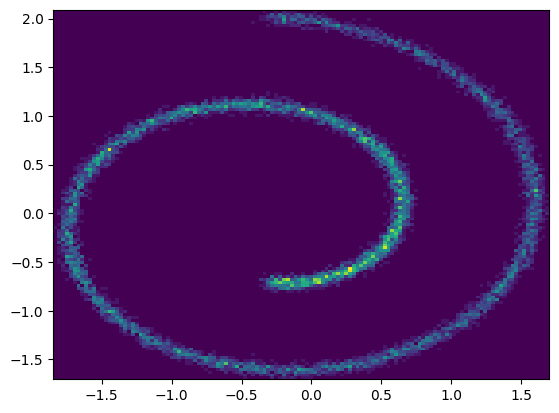

In [24]:
def get_data(dataset: str, n_points: int) -> np.ndarray:
  if dataset == "moons":
    data, _ = make_moons(n_points, noise=0.15)
  elif dataset == "swiss":
    data, _ = make_swiss_roll(n_points, noise=0.25)
    data = data[:, [0, 2]] / 10.0
  return StandardScaler().fit_transform(data)


n_points = 10_000
DATASET = "swiss"
data = get_data(DATASET, n_points)

%matplotlib inline
plt.hist2d(data[:, 0], data[:, 1], bins=128)
plt.show()

We then transform the data points into a ```pytorch.utils.data.DataLoader``` to facilitate data handling. We set the ```batch_size``` to $512$.

In [25]:
batch_size = 2048
dataset = torch.from_numpy(data).float()
dataset = dataset.to(device)
dataset = TensorDataset(dataset)
dataloader = DataLoader(dataset, batch_size=batch_size)

## Training:

We train the neural network using the ```AdamW``` optimizer (Adam optimizer with _weight decay_) with a _learning rate_ $lr = 10^{-3}$ during $N = 500$ epochs:

In [26]:
def get_model(name: str):
    if name == "vp":
      return VPDiffusionFlowMatching()
    elif name == "ve":
      return VEDiffusionFlowMatching()
    if name == "ot":
      return OTFlowMatching()

MODEL = "ot"
model = get_model(MODEL)
net = Net(2, 2, [512]*5, 10).to(device)
v_t = CondVF(net)

losses = []
# configure optimizer
optimizer = torch.optim.Adam(v_t.parameters(), lr=1e-3)
n_epochs = 5000

for epoch in tqdm(range(n_epochs), ncols=88):
    for batch in dataloader:
      x_1 = batch[0]
      # compute loss
      loss = model.loss(v_t, x_1)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses += [loss.detach()]

100%|███████████████████████████████████████████████| 5000/5000 [06:10<00:00, 13.49it/s]


## Sampling:

To sample $\hat{x}_{1} \sim q(x_1)$ we first sample $x_0 \sim p(x)$, _i.e._ we draw samples from the _prior distribution_, and then apply the ```decode``` function from the ```CondVF``` class. This step may take several minutes depending on the ```n_samples``` chosen.

In [27]:
# Sampling
n_samples = 10_000
with torch.no_grad():
    x_0 = torch.randn(n_samples, 2, device=device)
    x_1_hat = v_t.decode(x_0)

Last, we plot the samples $\hat{x}_1$ distribution:

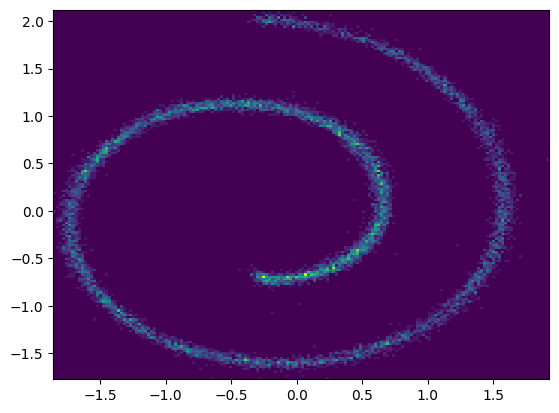

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
x_1_hat = x_1_hat.cpu().numpy()
plt.hist2d(x_1_hat[:, 0], x_1_hat[:, 1], bins=164)
plt.show()

In [29]:
# Sampling
N_SAMPLES = 10_000
N_STEPS = 100
t_steps = torch.linspace(0, 1, N_STEPS, device=device)
with torch.no_grad():
    x_t = [torch.randn(n_samples, 2, device=device)]
    for t in range(len(t_steps)-1):
      x_t += [v_t.decode_t0_t1(x_t[-1], t_steps[t], t_steps[t+1])]

# pad predictions
x_t = [x_t[0]]*10 + x_t + [x_t[-1]] * 10

x_t_numpy = np.array([x.detach().cpu().numpy() for x in x_t])
filename = f"{DATASET}_{MODEL}_{N_SAMPLES}_{N_STEPS}.npy"
np.save(filename, x_t_numpy)


# Evaluate NN

In [32]:
data.shape

(10000, 2)

In [45]:
data_tensor = torch.from_numpy(data).float()
data_tensor = data_tensor.to(device)

data_encoded = v_t.encode(data_tensor)

In [48]:
data_encoded = data_encoded.detach().cpu().numpy()

In [50]:
print(data.shape)
print(data_encoded.shape)

(10000, 2)
(10000, 2)


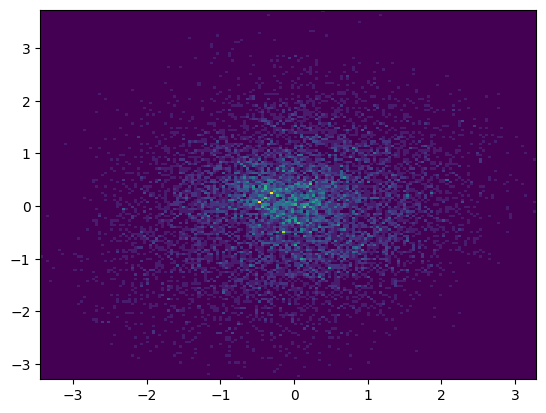

In [57]:
%matplotlib inline
plt.hist2d(data_encoded[:, 0], data_encoded[:, 1], bins=164)
plt.show()

In [58]:
import pandas as pd


df = pd.DataFrame({
    'data_x': data[:,0],
    'data_y': data[:,1],
    'data_encoded_x': data_encoded[:,0],
    'data_encoded_y': data_encoded[:,1],
})
df.to_csv('data-data_encoded.csv', index=False)

In [70]:
from sklearn.neighbors import NearestNeighbors


nbrs = NearestNeighbors(n_neighbors=11, algorithm='kd_tree').fit(data)
distances, indices = nbrs.kneighbors(data)

nbrs_enc = NearestNeighbors(n_neighbors=11, algorithm='kd_tree').fit(data_encoded)
distances_enc, indices_enc = nbrs_enc.kneighbors(data_encoded)

In [73]:
indices = indices[:,1:]
indices_enc = indices_enc[:,1:]

In [82]:
n_total = indices.shape[0] * indices.shape[1]
n_shared = 0

for i in range(len(indices)):
    s1 = indices[i]
    s2 = indices_enc[i]
    intersection = set(s1).intersection(s2)
    n_shared += len(intersection)

print(f'Total Recall: {round(100 * n_shared / n_total, 2)}%')

Total Recall: 33.75%
